## Objective 



## **Introduction**
**In this competition, we develop a model to predict future relative return of stock price performance during the final minutes of the trading hour**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


## **Importing Libraries**

In [3]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
temp = dict(layout = go.Layout(font = dict(family="Franklin Gothic", size=12), width = 1500))

import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split
import time


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **Load Dataset**

In [4]:
df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [6]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

## Exploring Data distributions:

In [7]:
df['target_'] = df['target'] >= 0

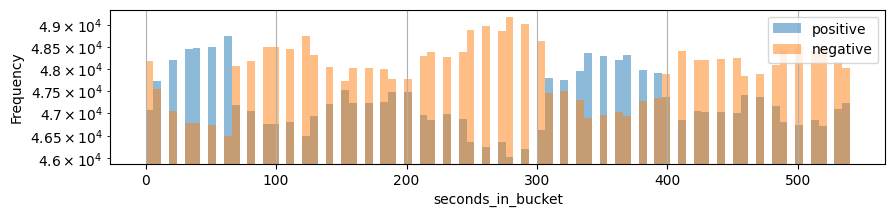

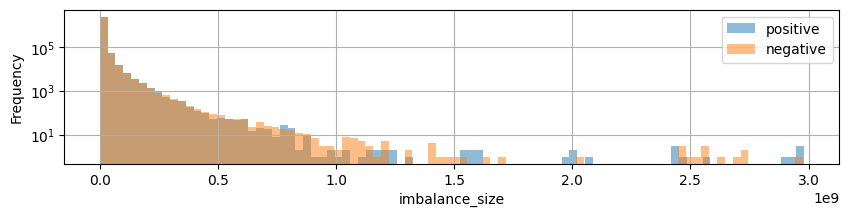

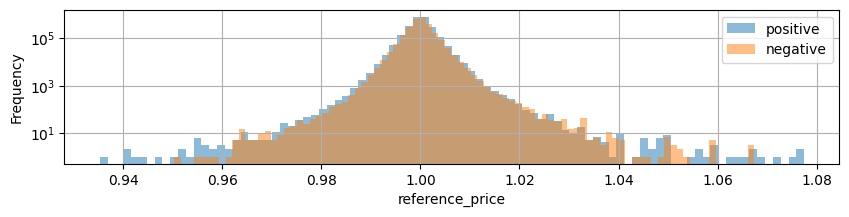

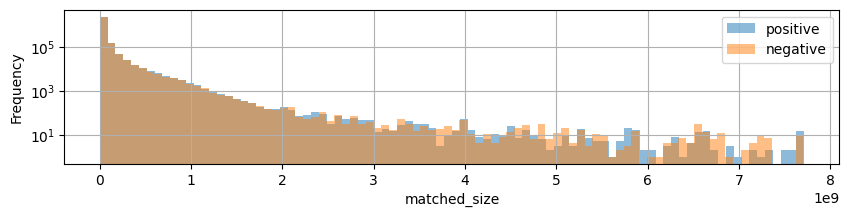

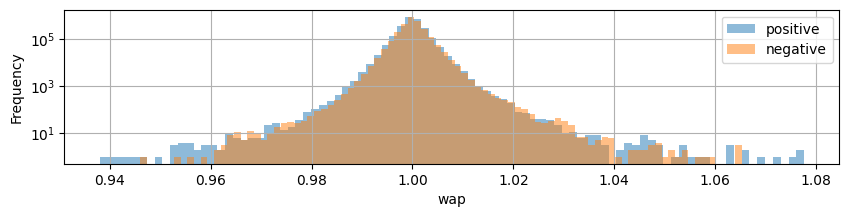

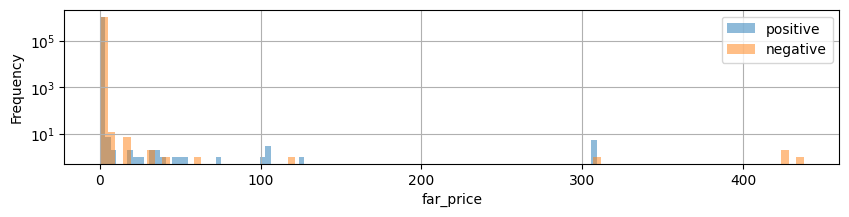

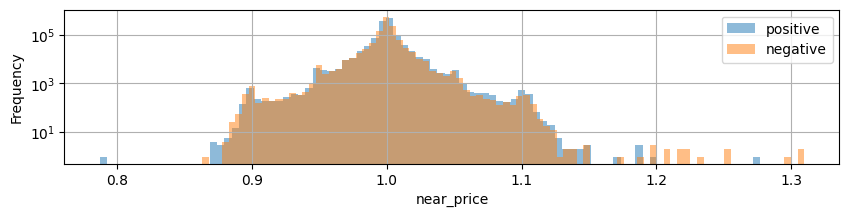

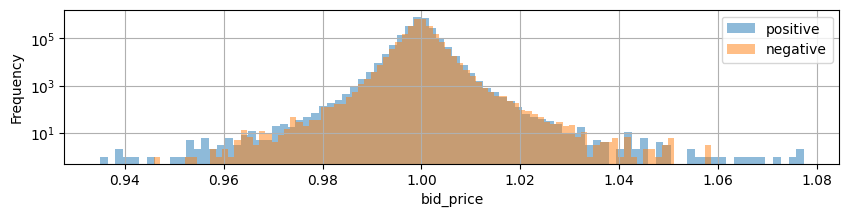

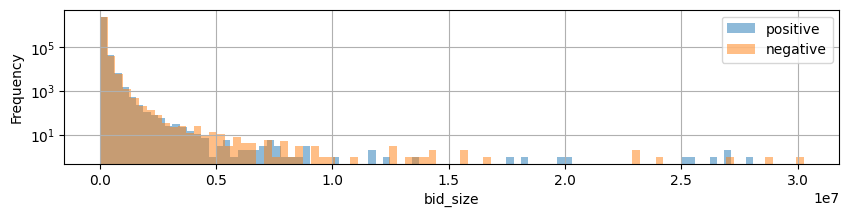

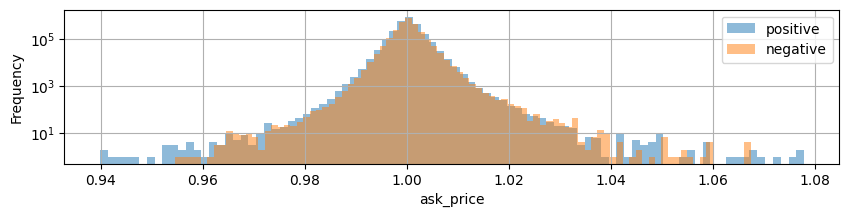

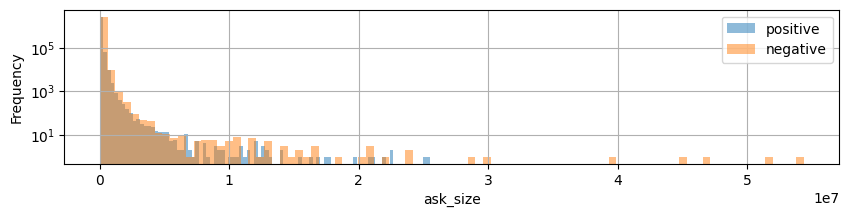

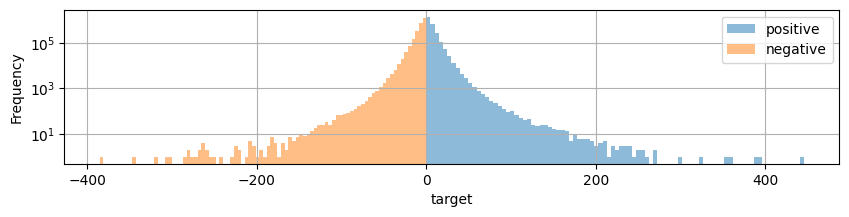

In [8]:
for col in ['seconds_in_bucket', 'imbalance_size', 'reference_price', 'matched_size', 'wap',
            'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'target']:
    fig = plt.figure(figsize=(10, 2))
    # sns.histplot(data=df_train, x=col, hue="target_", ax=fig.gca())
    hist_kwargs = dict(ax=fig.gca(), alpha=0.5, bins=90, logy=True, xlabel=col, grid=True)
    df[df['target_']][col].plot.hist(label="positive", **hist_kwargs)
    df[~df['target_']][col].plot.hist(label="negative", **hist_kwargs)
    fig.gca().legend()

In [9]:
grouped_trade = df.groupby(["stock_id"]).agg({"bid_price": ["mean", "std", "count"],  # Count here gives the number of trades
                                                    "target": ["mean", "std", "sum"],
                                                    "bid_size": ["mean", "std", "sum"]}).reset_index()

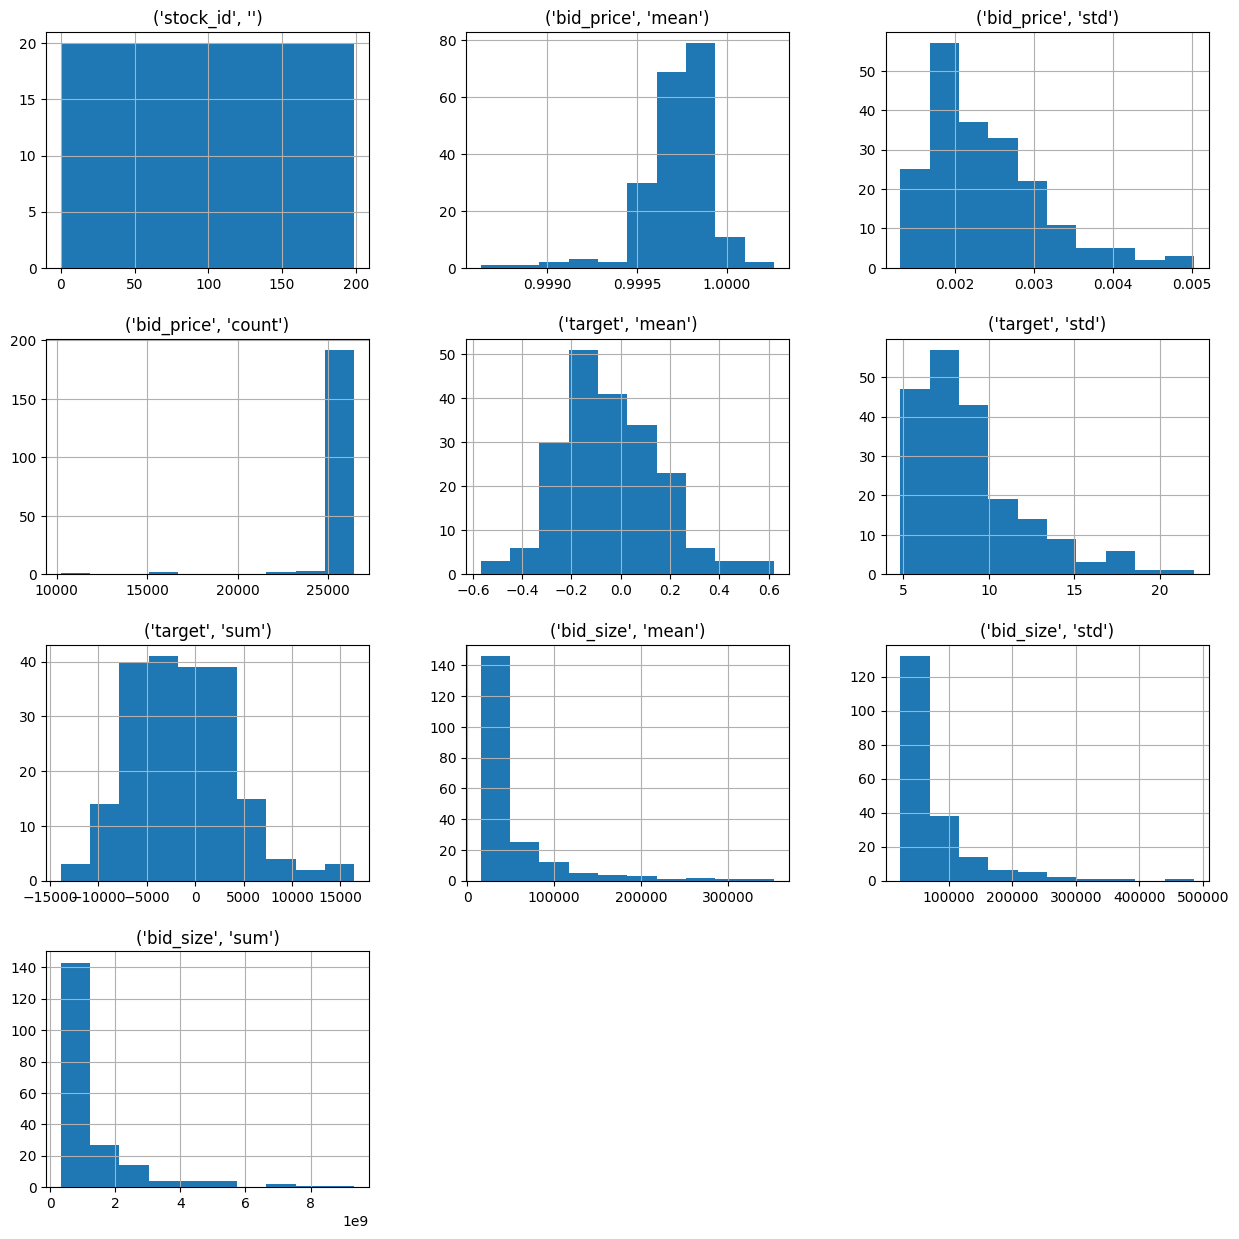

In [10]:

grouped_trade.hist(figsize=(15, 15));

In [11]:
def inspect_columns(df):
    
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,4,199,int64
date_id,False,481,False,0.00,0,11,480,int64
seconds_in_bucket,False,55,False,0.00,0,140,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,0.0,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,0,-1,int64
reference_price,False,28741,True,0.00,0.999812,1.000534,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,8586959.35,24073677.32,float64
far_price,False,95739,True,55.26,NaN,NaN,1.000859,float64
near_price,False,84625,True,54.55,NaN,NaN,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,1.00038,1.002129,float64


/tmp/ipykernel_42/1370788959.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['target'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


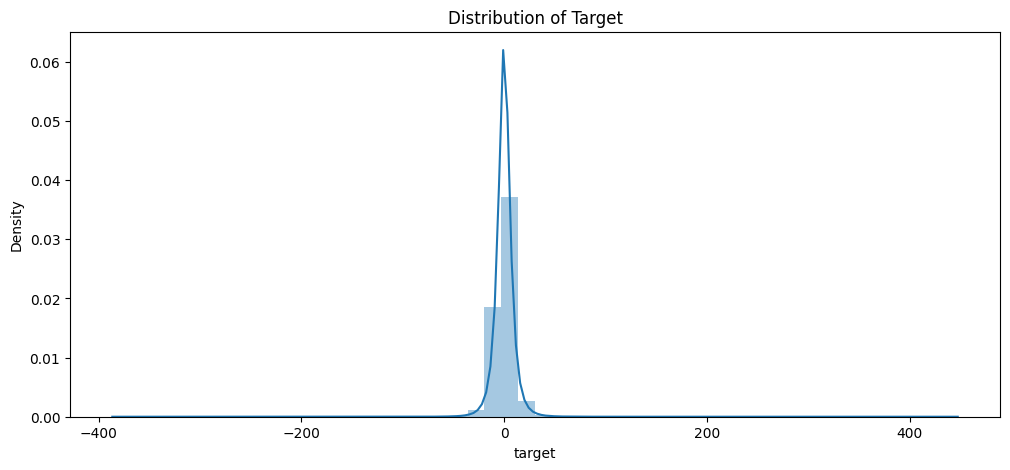

In [12]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Target")
ax = sns.distplot(df['target'])

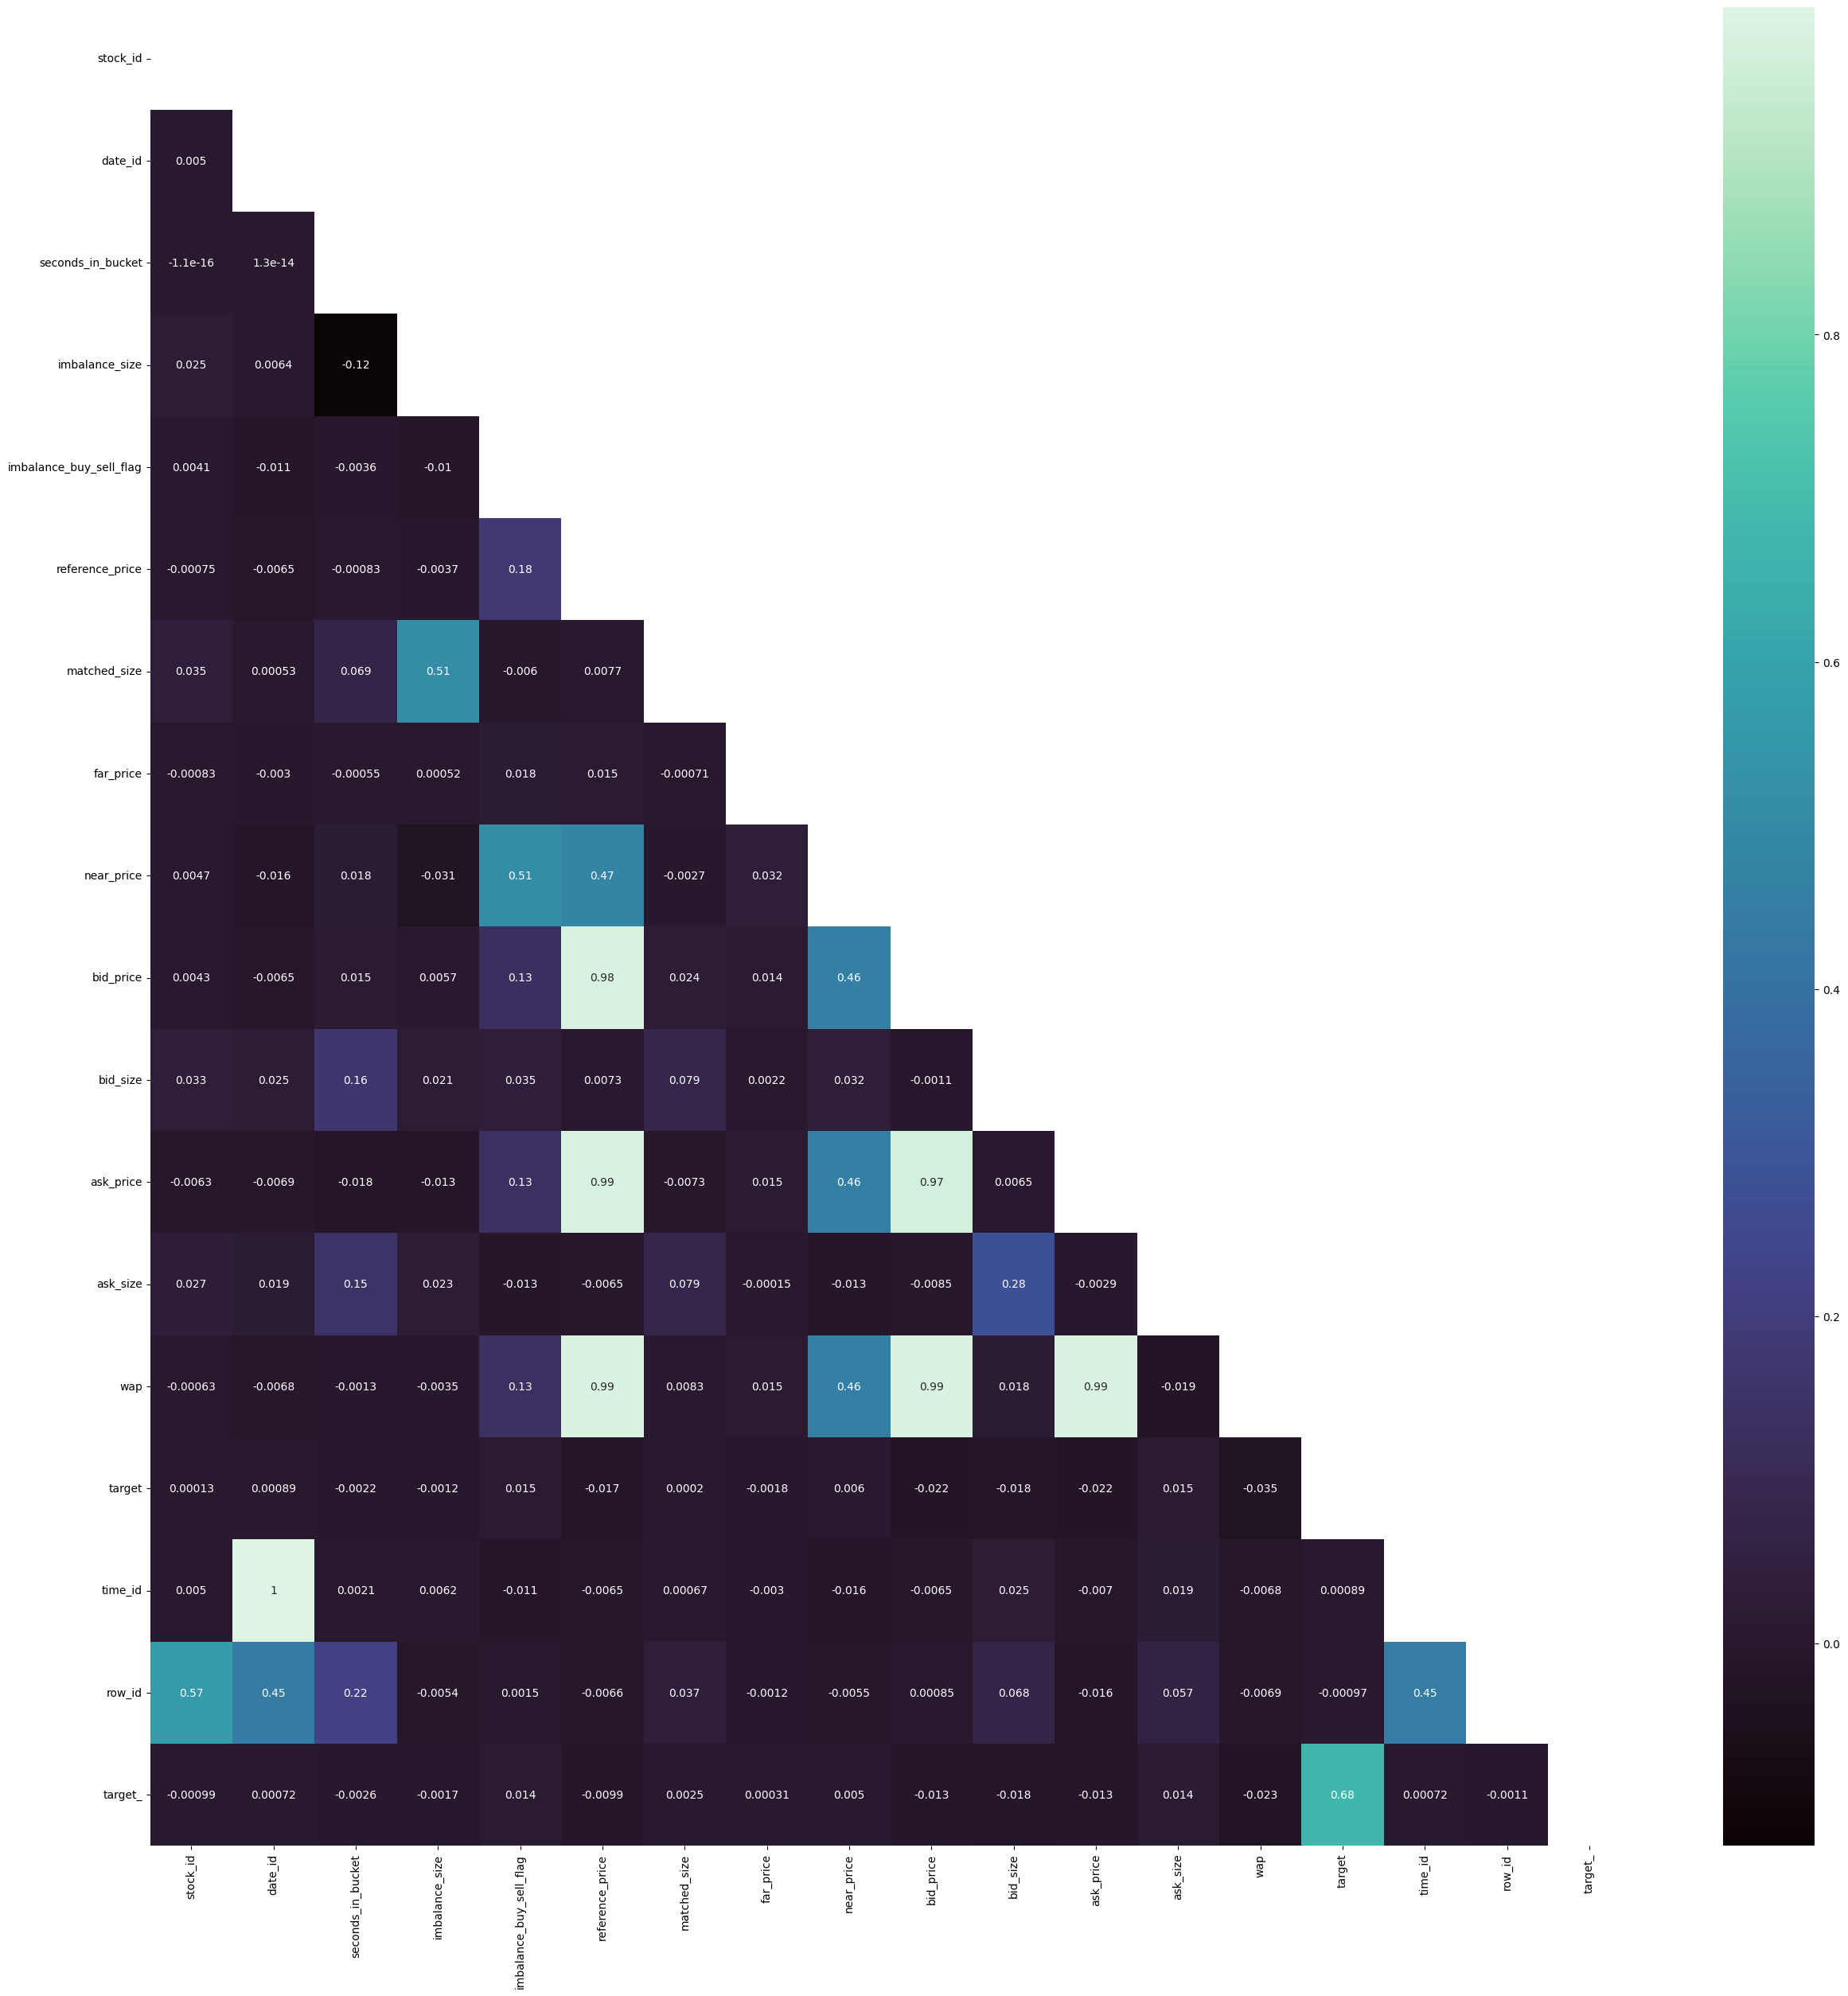

In [13]:
plt.figure(figsize=(30,30))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

* Now, Create new columns with shifted values for the current column. Missing values are filled with the mean calculated earlier.

* Merges the DataFrame with the first value of the grouped column for each group. This is done based on the "date_id" and "stock_id" columns, and suffixes are added to distinguish original columns from those representing the first values.

In [15]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,target_
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,False
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,False
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,False
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,False
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,False


In [16]:
SEED = 42

N_LAGS = 55

BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 10000
PATIENCE = 25
DROPOUT = 0.5
LEARNING_RATE = 1e-4

SPLIT_DAY = 390

N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

RUN_TRAINING = True
RUN_FOR_SUBMISSION = True

In [17]:
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df.shape

(5237980, 4)

In [18]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 39.96 MB
Decreased by 75.00%


/tmp/ipykernel_42/3839830161.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int16)
/tmp/ipykernel_42/3839830161.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int16)
/tmp/ipykernel_42/3839830161.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [19]:
all_stock_ids = range(N_STOCKS)
all_date_ids = range(N_DATES)
all_seconds = [i * 10 for i in range(N_SECONDS)]

multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds], 
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
df_full = df_full.fillna(0)
df_full = df_full.reset_index()

assert(df_full.shape[0] == N_STOCKS * N_DATES * N_SECONDS)

df_full

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029297
1,0,0,10,0.389893
2,0,0,20,4.218750
3,0,0,30,5.449219
4,0,0,40,3.169922
...,...,...,...,...
5290995,199,480,500,-7.210938
5290996,199,480,510,-9.750000
5290997,199,480,520,3.630859
5290998,199,480,530,4.761719


In [23]:
features = df_full[['stock_id', 'date_id', 'seconds_in_bucket']].values
target = df_full['target'].values

In [26]:
means=features.mean(0)
std=features.std(0)

In [29]:
def normalize_features(x):
    return (x - means) / (std+1e-8)

In [30]:
x = normalize_features(features)
y=target

In [31]:
features

array([[  0,   0,   0],
       [  0,   0,  10],
       [  0,   0,  20],
       ...,
       [199, 480, 520],
       [199, 480, 530],
       [199, 480, 540]])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
def get_dataloaders(x,y, batch_size=512):
    x_tensor = torch.Tensor(x).to(device)
    y_tensor = torch.Tensor(y).to(device)
    
    full_dataset = TensorDataset(x_tensor, y_tensor)
    train_dataset, test_dataset = random_split(full_dataset, [0.8,0.2])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=min(batch_size*4, len(test_dataset)), drop_last=True)
    return (train_dataloader, test_dataloader)

train_dataloader, test_dataloader = get_dataloaders(x,y)

In [39]:
def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, shortcut=0):
    size = len(dataloader.dataset)
    model.train()
    num_batches = len(dataloader)

    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X)
        
#         print(pred.detach().numpy().flatten())
        
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if pred.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break
        
        if shortcut > 0 and batch == shortcut:
            return train_loss.detach().cpu().numpy() / shortcut
    return train_loss.detach().cpu().numpy() / num_batches


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
      
            
            pred = model(X)
            test_loss += loss_fn(pred, y).detach().cpu().numpy()
    
        scheduler.step(test_loss)
    return test_loss / num_batches
        
def predict(X, model):
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy().flatten()